# DENSER
My implementation of DENSER, a method for architecture selection in neural networks. The paper can be found [here](https://arxiv.org/abs/2004.11002).


## TO DO:
- [ ] Implement crossover in GA class
- [ ] Implement crossover in DSGE class
- [ ] Implement mutation in GA class
- [ ] Implement genetic algorithm

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from scripts import utils, train
from scripts.dataloader import cifar10, MINST
import copy

%load_ext autoreload
%autoreload 2

## Build the encoder from the DENSER paper 

Fristly we define the lower lavel of the grammatic: a DSGE gene. This class encode a single layer from all the possible one (conv, pool, activation). 
In addition, the class compute the input channels and the output channels of the layer, which depends on the kernel size and the padding.

In [2]:
class DSGE_types(Enum):
    "Layer types for DSGE."
    POOLING = 1
    CONV = 2
    ACTIVATION = 3
    LINEAR = 4

class DSGE_pooling(Enum):
    "Pooling types for DSGE."
    MAX = 1
    AVG = 2

class DSGE_activation(Enum):
    "Activation types for DSGE."
    RELU = 1
    SIGMOID = 2
    TANH = 3
    SOFTMAX = 4

class DSGE_genes:
    "DSGE_encoding class. The DSGE_encoding is composed of a list of genes."
    def __init__(self, type=None, c_in = None, c_out = None, param=None):
        if type is None: # Random init, no type specified (could be pooling, conv, activation, linear)
            self.random_init()
        else:
            self.init_form_encoding(type, param)
        self.channels = {'in': c_in, 'out': c_out}

        
        

        
        
    def random_init(self):
        self.type = DSGE_types(np.random.randint(1, 5))  #randomly choose a type
        self.random_init_param()                  #randomly choose the parameters of the type

    def random_init_param(self):
        if self.type == DSGE_types.POOLING:           #randomly choose a pooling type
            self.param = {"pool_type" : DSGE_pooling(np.random.randint(1, 3)), "kernel_size": np.random.randint(2, 5), "stride": np.random.randint(1, 3), "padding": np.random.randint(0, 2)}
        elif self.type == DSGE_types.CONV:         #randomly choose a kernel size, stride and padding
            self.param = {'kernel_size': np.random.randint(1, 9), 'stride': np.random.randint(1, 2), 'padding': np.random.randint(1, 2)}
        elif self.type == DSGE_types.ACTIVATION:   #randomly choose an activation type
            self.param = DSGE_activation(np.random.randint(1, 4))
        elif self.type == DSGE_types.LINEAR:     #linear layer has no parameters
            self.param = None
    
    def init_form_encoding(self, type, param=None):
        self.type = type   #set the type
        if param is None:   #if no parameters are specified, randomly choose them
            self.random_init_param()
        
    def compute_shape(self, input_shape):
        if self.type == DSGE_types.CONV or self.type == DSGE_types.POOLING:
            return utils.compute_output_conv2d(input_shape, kernel_size=self.param['kernel_size'], stride=self.param['stride'], padding=self.param['padding'])
        else:
            return input_shape
    def get(self):  #return the gene
        return self.type, self.param, self.channels

            
        
        




Then we are ready to encode the outer levels, the GA types, which describe a single block of the network (a sequence of DSGE genes). A block could be a features block (conv, pool, activation) or a classifier block (linear, activation). The GA types are encoded in the class GA_type.

In [3]:
class GA_types(Enum):
    "Layer types for GA."
    FEATURES = 1
    CLASSIFICATION = 2
    LAST_LAYER = 3

class GA_genes:
    "GA_encoding class. The GA_encoding is composed of a list of genes."
    def __init__(self, GA_type, c_in = None, c_out = None):
        self.GA_type = GA_type #set the type
        self.dsge_encoding = []
        self.param  = {"input_channels": c_in, 'output_channels': c_out}
        

        if self.GA_type == GA_type.CLASSIFICATION :
            self.dsge_encoding.append(DSGE_genes(DSGE_types.LINEAR, c_in = c_in, c_out = c_out    ))
            self.dsge_encoding.append(DSGE_genes(DSGE_types.ACTIVATION, c_in = c_out, c_out = c_out  ))
            
        if self.GA_type == GA_type.LAST_LAYER :
            self.dsge_encoding.append(DSGE_genes(DSGE_types.LINEAR, c_in = c_in, c_out = c_out    ))

        if self.GA_type == GA_type.FEATURES:
            self.dsge_encoding.append(DSGE_genes(DSGE_types.CONV, c_in = c_in, c_out = c_out  ))
            self.dsge_encoding.append(DSGE_genes(DSGE_types.ACTIVATION, c_in = c_out, c_out = c_out ) )
            self.dsge_encoding.append(DSGE_genes(DSGE_types.POOLING, c_in = c_out, c_out = c_out  ))
        self.dsge_len = len(self.dsge_encoding)    

    def compute_shape(self, input_shape):
        output_shape = input_shape
        for i in range(self.dsge_len):
            output_shape = self.dsge_encoding[i].compute_shape(output_shape)
        return output_shape

    def get(self):
        return self.GA_type, self.dsge_encoding, self.param

    def print(self): #print the GA_encoding
        print( self.GA_type)
        for i in range(len(self.dsge_encoding)):
            print( self.dsge_encoding[i].get())
        print("param: ", self.param)
            

Finally, we encode the whole network, the GA, which is a sequence of GA types:

In [4]:
class Net_encoding:
    "Describe the encoding of a network."
    def __init__(self, num_features, num_classification, c_in , c_out, input_shape):
  
        self.GA_features = []
        self.GA_classification = []
        self.GA_last_layer = []
        
        channels = self.init_random_channel(c_in, c_out, num_features + num_classification )
        


        for i in range(num_features):
            self.GA_features.append(   GA_genes(GA_types.FEATURES, c_in = channels[i][0], c_out = channels[i][1]   )    )
            
        k = num_features
        channels[k] = ( (self.compute_shape_features(input_shape) ** 2) * channels[k-1][1], channels[k][1])   #set the input channels of the classification block: the flatten output of the features block
        for i in range(num_classification - 1):
            self.GA_classification.append(   GA_genes(     GA_types.CLASSIFICATION,  c_in = channels[k+i][0], c_out = channels[k+i][1]  )  )

        self.GA_last_layer.append(GA_genes( GA_types.LAST_LAYER,  c_in = channels[self.num_classification() + k][0], c_out = c_out)  )
        
 
        self.param = {'input_channels': c_in ,'output_channels': c_out}
        
    def _len(self):
        x =  len(self.GA_features) +  len(self.GA_classification) + 1
        return  x #the length of the encoding is the number of features block and classification block
    def num_features(self):
        x = len(self.GA_features)
        return x
    def num_classification(self):
        x = len(self.GA_classification) 
        return x  

    def GA_encoding(self, i):
        if i < self.num_features():
            return self.GA_features[i]
        elif i < self.num_features() + self.num_classification():
            return self.GA_classification[i - self.num_features() ]
        elif i == self.num_features() + self.num_classification():
            return self.GA_last_layer[0]
        else:
            return self.GA_last_layer[0]

    def init_random_channel(self, C_in, C_out, len):
        tmp = C_in
        channels = []
        for i in range(len-1):
            out  = np.random.randint(3,30)
            channels.append( (tmp, out ) )
            tmp = out

        channels.append((tmp, C_out))
        return channels
    
    def compute_shape_features(self, input_shape = 32):
        output_shape = input_shape
        for i in range(self.num_features()):
            output_shape = self.GA_features[i].compute_shape(output_shape)
        return output_shape

    def get(self):
        return self.GA_encoding
        
    def print(self):
        print("Net encoding len:", self._len())
        for i in range(self._len()):
            print( self.GA_encoding(i).print())

    def print_GAlevel(self):
        print("Net len:", self._len())
        for i in range(self._len()):
            print("-",i, self.GA_encoding(i).GA_type)

    def fix_channels

def GA_crossover(parent1, parent2):
        #find cutting point
        cut_parent1 = np.random.randint(0, parent1._len() -1)
        cut_parent2 = np.random.randint(0, parent2._len() -1)
        

        #identify the type of the cut
        cut1_type = parent1.GA_encoding(cut_parent1).GA_type
        cut2_type = parent2.GA_encoding(cut_parent2).GA_type

        print("cut1_type: ", cut1_type, "cut", cut_parent1)
        print("cut2_type: ", cut2_type, "cut", cut_parent2)

        if cut1_type == cut2_type and cut1_type == GA_types.FEATURES:
            print("FEATURES")
            aux1 = copy.deepcopy(parent1.GA_features[cut_parent1:])
            aux2 = copy.deepcopy(parent2.GA_features[cut_parent2:])
   
            parent1.GA_features = copy.deepcopy(parent1.GA_features[:cut_parent1])
            parent2.GA_features = copy.deepcopy(parent2.GA_features[:cut_parent2])
            
            parent1.GA_features.extend(aux2)
            parent2.GA_features.extend(aux1)

            return parent1, parent2
        if cut1_type == cut2_type and cut1_type == GA_types.CLASSIFICATION:
            print("CLASSIFICATION")
            aux1 = copy.deepcopy(parent1.GA_classification[cut_parent1 - parent1.num_features():])
            aux2 = copy.deepcopy(parent2.GA_classification[cut_parent2 - parent2.num_features():])
   
            parent1.GA_classification = copy.deepcopy(parent1.GA_classification[:cut_parent1 - parent1.num_features()])
            parent2.GA_classification = copy.deepcopy(parent2.GA_classification[:cut_parent2 - parent2.num_features()])
            
            parent1.GA_classification.extend(aux2)
            parent2.GA_classification.extend(aux1)

            return parent1, parent2

        return 


In [61]:
x = [1,2,3,4,5]
print(x[2:])
print(x[:2])

[3, 4, 5]
[1, 2]


In [103]:
parent1 = Net_encoding(12, 2, 3, 10, 32)
parent2 = Net_encoding(3, 2, 3, 10, 32)
parent1.print_GAlevel()
parent2.print_GAlevel()
child1, child2 = GA_crossover(parent1, parent2)
child1.print_GAlevel()
child2.print_GAlevel()

Net len: 14
- 0 GA_types.FEATURES
- 1 GA_types.FEATURES
- 2 GA_types.FEATURES
- 3 GA_types.FEATURES
- 4 GA_types.FEATURES
- 5 GA_types.FEATURES
- 6 GA_types.FEATURES
- 7 GA_types.FEATURES
- 8 GA_types.FEATURES
- 9 GA_types.FEATURES
- 10 GA_types.FEATURES
- 11 GA_types.FEATURES
- 12 GA_types.CLASSIFICATION
- 13 GA_types.LAST_LAYER
Net len: 5
- 0 GA_types.FEATURES
- 1 GA_types.FEATURES
- 2 GA_types.FEATURES
- 3 GA_types.CLASSIFICATION
- 4 GA_types.LAST_LAYER
cut1_type:  GA_types.FEATURES cut 7
cut2_type:  GA_types.FEATURES cut 0
FEATURES
Net len: 12
- 0 GA_types.FEATURES
- 1 GA_types.FEATURES
- 2 GA_types.FEATURES
- 3 GA_types.FEATURES
- 4 GA_types.FEATURES
- 5 GA_types.FEATURES
- 6 GA_types.FEATURES
- 7 GA_types.FEATURES
- 8 GA_types.FEATURES
- 9 GA_types.FEATURES
- 10 GA_types.CLASSIFICATION
- 11 GA_types.LAST_LAYER
Net len: 7
- 0 GA_types.FEATURES
- 1 GA_types.FEATURES
- 2 GA_types.FEATURES
- 3 GA_types.FEATURES
- 4 GA_types.FEATURES
- 5 GA_types.CLASSIFICATION
- 6 GA_types.LAST_LAYER

Let's try to build a network with 4 features blocks and 2 classifier blocks, with a 3 channel input (a standard RGB image) and a 10 channel output (class of CIFAR-10):

In [10]:
netcode = Net_encoding( 2, 3, 3, 10, 32 )
netcode.print()


Net encoding len: 5
GA_types.FEATURES
(<DSGE_types.CONV: 2>, {'kernel_size': 1, 'stride': 1, 'padding': 1}, {'in': 3, 'out': 12})
(<DSGE_types.ACTIVATION: 3>, <DSGE_activation.SIGMOID: 2>, {'in': 12, 'out': 12})
(<DSGE_types.POOLING: 1>, {'pool_type': <DSGE_pooling.MAX: 1>, 'kernel_size': 3, 'stride': 2, 'padding': 0}, {'in': 12, 'out': 12})
param:  {'input_channels': 3, 'output_channels': 12}
None
GA_types.FEATURES
(<DSGE_types.CONV: 2>, {'kernel_size': 8, 'stride': 1, 'padding': 1}, {'in': 12, 'out': 11})
(<DSGE_types.ACTIVATION: 3>, <DSGE_activation.SIGMOID: 2>, {'in': 11, 'out': 11})
(<DSGE_types.POOLING: 1>, {'pool_type': <DSGE_pooling.MAX: 1>, 'kernel_size': 3, 'stride': 2, 'padding': 1}, {'in': 11, 'out': 11})
param:  {'input_channels': 12, 'output_channels': 11}
None
GA_types.CLASSIFICATION
(<DSGE_types.LINEAR: 4>, None, {'in': 396, 'out': 15})
(<DSGE_types.ACTIVATION: 3>, <DSGE_activation.RELU: 1>, {'in': 15, 'out': 15})
param:  {'input_channels': 396, 'output_channels': 15}
N

## From the encoding to the neural network
Now we can build the neural network module from the encoding. We have only to select the correct layer from the DSGE gene and to connect them in the correct order. All the information are contained in the Net_encoding class.

In [13]:

class Net(nn.Module):
    def __init__(self, Net_encod):
        super().__init__()
        
        self.layer_list = []
  

        for i in range(Net_encod.num_features()):
            for j in range(Net_encod.GA_encoding(i).dsge_len):
                layer = self.make_layer(Net_encod.GA_encoding(i).dsge_encoding[j])
                self.layer_list.append(layer)

        self.layer_list.append(nn.Flatten() )

        for i in range(Net_encod.num_classification()):
            for j in range(Net_encod.GA_encoding(Net_encod.num_features() + i).dsge_len):
                self.layer_list.append( self.make_layer(Net_encod.GA_encoding(Net_encod.num_features() + i).dsge_encoding[j]))
        self.layer_list.append(self.make_layer(Net_encod.GA_last_layer[0].dsge_encoding[0]) )
        self.layers = nn.Sequential(*self.layer_list)


    def make_layer(self, dsge_encod):
            if dsge_encod.type == DSGE_types.CONV:
                return nn.Conv2d(dsge_encod.channels['in'], dsge_encod.channels['out'], dsge_encod.param['kernel_size'], dsge_encod.param['stride'], dsge_encod.param['padding'])
            if dsge_encod.type == DSGE_types.LINEAR:
                    return nn.Linear(dsge_encod.channels['in'], dsge_encod.channels['out'])
            if dsge_encod.type == DSGE_types.ACTIVATION:
                if dsge_encod.param == DSGE_activation.RELU:
                    return nn.ReLU()
                if dsge_encod.param == DSGE_activation.SIGMOID:
                    return nn.Sigmoid()
                if dsge_encod.param == DSGE_activation.TANH:
                    return nn.Tanh()
            if dsge_encod.type == DSGE_types.POOLING:
                if dsge_encod.param["pool_type"] == DSGE_pooling.MAX:
                    return nn.MaxPool2d(dsge_encod.param['kernel_size'], dsge_encod.param['stride'], dsge_encod.param['padding'])
                if dsge_encod.param["pool_type"] == DSGE_pooling.AVG:
                    return nn.AvgPool2d(dsge_encod.param['kernel_size'], dsge_encod.param['stride'], dsge_encod.param['padding'])
    def forward(self, x):
        return self.layers(x)
 


Let's try the network on MINST:

In [6]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# We download the train and the test dataset in the given root and applying the given transforms
trainset = torchvision.datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,  download=True, transform=transform)

batch_size=4

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,  shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 1, 28, 28])


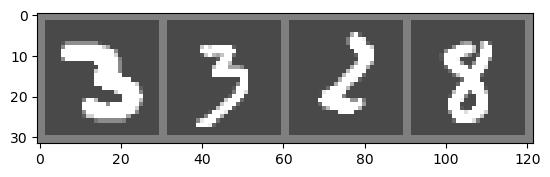

tensor([3, 3, 2, 8])
tensor([[ 0.5459,  0.1886,  0.0196,  0.2765, -0.3400,  0.6505, -0.3015, -0.7627,
          0.1804, -0.2225],
        [ 0.5484,  0.1888,  0.0194,  0.2740, -0.3411,  0.6529, -0.3015, -0.7629,
          0.1798, -0.2212],
        [ 0.5461,  0.1885,  0.0230,  0.2776, -0.3396,  0.6535, -0.2989, -0.7637,
          0.1814, -0.2201],
        [ 0.5480,  0.1899,  0.0217,  0.2778, -0.3402,  0.6520, -0.3020, -0.7630,
          0.1815, -0.2222]], grad_fn=<AddmmBackward0>)


In [14]:
images , classes = next(iter(trainloader))
netcode = Net_encoding( 4, 1, 1, 10 , 28)
model = Net(netcode)
def imgshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
print(images.shape)
imgshow(torchvision.utils.make_grid(images))
print(classes)
print(model(images))


In [8]:
netcode.print()

Net encoding len: 5
GA_types.FEATURES
(<DSGE_types.CONV: 2>, {'kernel_size': 6, 'stride': 1, 'padding': 1}, {'in': 1, 'out': 16})
(<DSGE_types.ACTIVATION: 3>, <DSGE_activation.SIGMOID: 2>, {'in': 16, 'out': 16})
(<DSGE_types.POOLING: 1>, {'pool_type': <DSGE_pooling.MAX: 1>, 'kernel_size': 2, 'stride': 1, 'padding': 0}, {'in': 16, 'out': 16})
param:  {'input_channels': 1, 'output_channels': 16}
None
GA_types.FEATURES
(<DSGE_types.CONV: 2>, {'kernel_size': 8, 'stride': 1, 'padding': 1}, {'in': 16, 'out': 16})
(<DSGE_types.ACTIVATION: 3>, <DSGE_activation.TANH: 3>, {'in': 16, 'out': 16})
(<DSGE_types.POOLING: 1>, {'pool_type': <DSGE_pooling.AVG: 2>, 'kernel_size': 4, 'stride': 1, 'padding': 0}, {'in': 16, 'out': 16})
param:  {'input_channels': 16, 'output_channels': 16}
None
GA_types.FEATURES
(<DSGE_types.CONV: 2>, {'kernel_size': 1, 'stride': 1, 'padding': 1}, {'in': 16, 'out': 12})
(<DSGE_types.ACTIVATION: 3>, <DSGE_activation.RELU: 1>, {'in': 12, 'out': 12})
(<DSGE_types.POOLING: 1>, {

In [11]:
trainloader, testloader, classes = cifar10()

Files already downloaded and verified
Files already downloaded and verified


Create a model with an architecture selected with the DENSER grammar:

In [15]:
model = Net(netcode)



In [9]:
from scripts.train import train, eval

In [16]:
train(model, trainloader, device="cuda")
eval(model, testloader, device="cuda")

100%|██████████| 12500/12500 [01:34<00:00, 132.35it/s]


Accuracy of the network on the 10000 test images: 94 %
